# Deep Learning project
Intro by Tatiana

In [ ]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Basis libraries
import os, re, sys, math, time, scipy, argparse
import cv2, matplotlib
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Section 0: Download and install repository
First, we will download the repository that we copied from the [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation) in order to make some changes for educational purposes. Then, we install libraries and some dependences explained in the original repository.

In [ ]:
# Independence install
!sudo apt-get install swig
%cd $colab_path
# Repository clone
!git clone https://github.com/Johansmm/RT-multiperson-pose-pytorch.git
%cd "RT-multiperson-pose-pytorch"
# Libraries install
!python -m pip install -r ./requirements.txt
!git submodule init && git submodule update
%cd lib/pafprocess 
# Repository compile
!sh make.sh
%cd $colab_path"/RT-multiperson-pose-pytorch"
# Weights download
if not os.path.isfile("./pose_model.pth"):
  !wget https://www.dropbox.com/s/ae071mfm2qoyc8v/pose_model.pth
output.clear()
print("[INFO]: Proyect uploaded successfully")

[INFO]: Proyect uploaded successfully


In [ ]:
!python demo/picture_demo.py

Bulding VGG19
0.5459940652818991


In [ ]:
# Framework libraries
%cd $colab_path"/RT-multiperson-pose-pytorch"
sys.path.append('.')
sys.path.append('./demo')
from lib.network.rtpose_vgg import get_model
from lib.network import im_transform
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config
from evaluate.coco_eval import get_outputs#, handle_paf_and_heat
data_download = False # For download COCO dataset

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


## Section 2: Replication of results
In this section we replicated some resutls. First, we need download the data. For this case, we will use the `sh` compiler provided by [original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation)

In [ ]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
if data_download and not os.path.isdir("data/coco"):
  !mkdir data
  %cd data
  !sh ../lib/datasets/CocoDataDownloader.sh
  %cd $colab_path"/RT-multiperson-pose-pytorch"
  output.clear()
  print("[INFO]: Coco database downloaded successfully")

Now, we defined some principal functions.

In [ ]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

def load_rtpose_model():
  args = Namespace(cfg = './experiments/vgg19_368x368_sgd.yaml', weight = 'pose_model.pth', opts = [])
  update_config(cfg, args)
  model = get_model('vgg19')     
  model.load_state_dict(torch.load(args.weight))
  model = torch.nn.DataParallel(model).cuda()
  model.float()
  model.eval()
  return model

def im_forward(image, model):
  with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(image, model, 'rtpose')
  return paf, heatmap, im_scale

model = load_rtpose_model()

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
Bulding VGG19


['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_get_uidx', 'add_pair', 'body_parts', 'get_face_box', 'get_max_score', 'get_upper_body_box', 'is_connected', 'merge', 'pairs', 'part_count', 'score', 'uidx_list']
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_get_uidx', 'add_pair', 'body_parts', 'get_face_box', 'get_max_score', 'get_upper_body_box', 'is_connected', 'merge', 'pairs', 'part_count', 'score', 'uidx_list']
['__class_

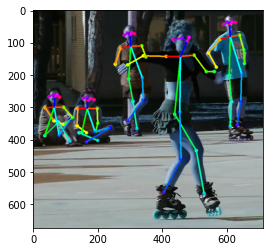

In [ ]:
image = cv2.imread('./readme/ski.jpg')
paf, heatmap, im_scale = im_forward(image, model)
humans = paf_to_pose_cpp(heatmap, paf, cfg)
for hum in humans:
  print(dir(hum))

out = draw_humans(image, humans)
plt.imshow(out)


In [1]:
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')

%cd "/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch"
!git config --global user.email "johan-steven.mejia-mogollon@imt-atlantique.com"
!git config --global user.name "Johansmm"
!git pull

Mounted at /content/gdrive
[Errno 2] No such file or directory: '$colab_path/RT-multiperson-pose-pytorch'
/content
fatal: not a git repository (or any of the parent directories): .git
